In [630]:
# Standard Library Imports
from collections import Counter
from tabnanny import verbose

# Third-Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from upsetplot import from_memberships, plot
from scipy.stats import chi2_contingency, f_oneway
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from matplotlib.patches import Ellipse


# scikit-learn Imports
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import umap


In [631]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/antibody_df.csv')

# Load the cytokines data
cytokines = pd.read_csv('../data/cytokines_data.csv')

# Load the cytometry data
cytometry = pd.read_csv('../data/cyto_data.csv')


Frequency of responses:
response_label
no response    29
response       11
Name: count, dtype: int64


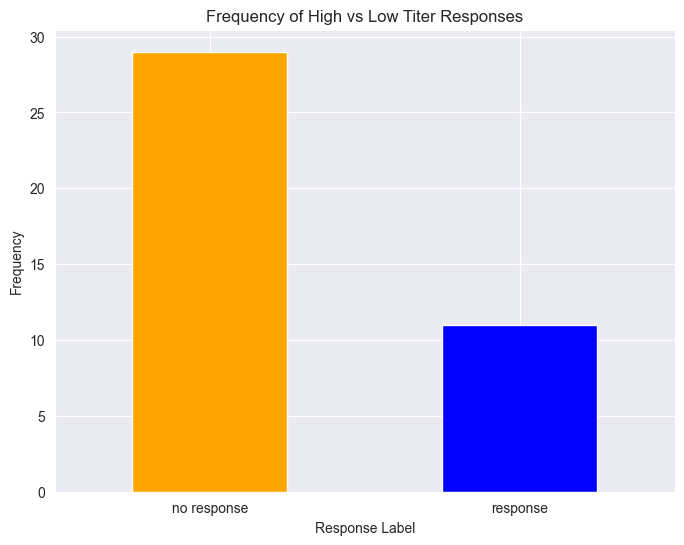

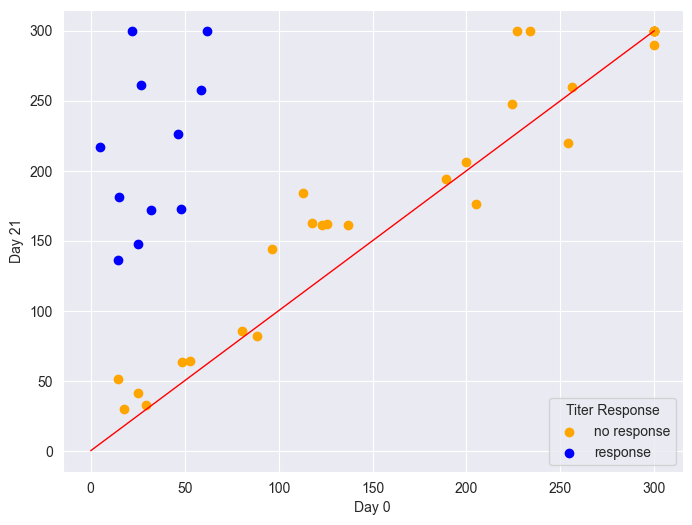

In [632]:
# Count the frequency of each label
abtiters['response_label'] = abtiters['quadrant'].apply(lambda x: 'response' if x == 'responder' else 'no response')

# Count the frequency of each label
response_counts = abtiters['response_label'].value_counts()

print("\nFrequency of responses:")
print(response_counts)

# Plot the frequency of high vs. low responses as a bar plot
plt.figure(figsize=(8, 6))
response_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title('Frequency of High vs Low Titer Responses')
plt.xlabel('Response Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

colors = {'response': 'blue', 'no response': 'orange'}
plt.figure(figsize=(8, 6))
for label, group in abtiters.groupby('response_label'):
    plt.scatter(group['Day 0'], group['Day 21'], color=colors[label], label=label)

# Plot reference line y = x
plt.plot([0, max(abtiters['Day 0'])], [0, max(abtiters['Day 21'])], color='red', linestyle='-', linewidth=1)

# Labeling and legend
plt.xlabel('Day 0')
plt.ylabel('Day 21')
plt.legend(title="Titer Response")
plt.show()

In [633]:
abtiters = abtiters.drop(columns=['vaccine', 'Day 0', 'Day 21', 'Day 150', 'Day 365', 'diff: 21-0', 'diff: 150-21', 'diff: 365-150', 'response', 'protected','quadrant'])
print(abtiters.head())

## abtiters already loaded ##
## cytokines already loaded ##
cytometry = cytometry[['Vaccinee', 'WBC Day 0','RBC Day 0','HGB Day 0','HCT Day 0','PLT Day 0','%LYM Day 0','%MON Day 0','%GRA Day 0']] # already loaded


metadata = pd.read_csv('../data/metadata.csv')

gender_mapping = {'M': 1, 'F': 0}
metadata['Gender'] = metadata['Gender'].map(gender_mapping)

  Vaccinee response_label
0       M1       response
1      M11    no response
2      M12    no response
3      M13    no response
4      M14       response


In [634]:
cytokines_cyto = pd.merge(cytokines, cytometry, on='Vaccinee')
merged = pd.merge(cytokines_cyto, metadata, on='Vaccinee')
merged_data = pd.merge(abtiters, merged, on='Vaccinee')

# Assuming 'merged_data' is loaded and structured with response labels and features
# Separate features and response labels
X = merged_data.drop(columns=['response_label', 'Vaccinee'])
y = merged_data['response_label']

In [635]:
def _add_reference_circles(ax, radii=[0.5, 1.0], color='gray', linestyle='--', linewidth=0.8, alpha=0.5):
    for radius in radii:
        circle = plt.Circle((0, 0), radius, color=color, fill=False, linestyle=linestyle, linewidth=linewidth, alpha=alpha)
        ax.add_artist(circle)

def plot_pca_with_response_marginals(
    data, 
    numeric_features=None, 
    response_label_col='response_label', 
    excluded_features=[],
    pc1_err_col=None, 
    pc2_err_col=None,
    verbose = False
):
    """
    Plots a PCA scatter plot with marginal boxplots grouped by response and non-response labels,
    and includes a biplot with feature contributions.

    Parameters:
    - data (pd.DataFrame): The input dataframe containing the data.
    - numeric_features (list, optional): List of numeric feature columns for PCA if 'PC1' and 'PC2' are not already in the dataframe.
    - response_label_col (str): Column indicating response labels (e.g., 'response' or 'no response').
    - pc1_err_col (str, optional): Column name for error values on PC1.
    - pc2_err_col (str, optional): Column name for error values on PC2.
    - feature_loading_threshold (float): Threshold to determine significant feature contributions.
    """
    loadings = None
    
    # Select numeric features for PCA
    if numeric_features is None:
        numeric_features = data.select_dtypes(include=[float, int]).columns.tolist()
        excluded_columns = [response_label_col, 'Vaccinee']
        excluded_columns.extend(excluded_features)
        numeric_features = [col for col in numeric_features if col not in excluded_columns]

    # Perform PCA if PC1 and PC2 do not exist
    if 'PC1' not in data.columns or 'PC2' not in data.columns:
        # Standardize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(data[numeric_features])
        
        # Perform PCA
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(X_scaled)
        data['PC1'] = principal_components[:, 0]
        data['PC2'] = principal_components[:, 1]
        
        # Identify top features contributing to each PCA component
        if verbose: print("\nFeature Contributions to PCA Components:")
        for i in range(2):  # For the first 2 components
            component_features = sorted(
                zip(numeric_features, pca.components_[i]),
                key=lambda x: abs(x[1]), 
                reverse=True
            )
            if verbose:
                print(f"Top features in PCA Component {i+1}:")
                for feature, loading in component_features:
                    print(f"  {feature}: {loading:.4f}")

        # Store PCA loadings for biplot
        loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Create the plot
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(2, 2, width_ratios=(7, 2), height_ratios=(2, 7), wspace=0.05, hspace=0.05)
    ax_scatter = fig.add_subplot(gs[1, 0])
    ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
    ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

    # Scatter plot grouped by response labels
    scatter_kwargs = {'data': data, 'x': 'PC1', 'y': 'PC2', 'ax': ax_scatter, 'alpha': 0.7}
    scatter_kwargs['hue'] = response_label_col
    sns.scatterplot(**scatter_kwargs)
    
    visual_multiplier = 3

    # Plot feature vectors (biplot arrows)
    for i, feature in enumerate(numeric_features):
        ax_scatter.scatter(
            loadings[i, 0] * visual_multiplier, loadings[i, 1] * visual_multiplier,  # Scale positions by 2
            color='red', alpha=0.8, marker='s', s=20, label=feature if i == 0 else ""  # Reduced size
        )
        # Scale the distance for the text positions
        ax_scatter.text(
            loadings[i, 0] * (visual_multiplier + 0.2), loadings[i, 1] * (visual_multiplier + 0.2),  # Scale positions by 2.2 for separation
            feature, color='black', ha='center', va='center', fontsize=9
        )
        
    # Add reference circles to indicate feature contribution thresholds
    _add_reference_circles(ax_scatter, radii=[0.5*visual_multiplier, 1.0*visual_multiplier], color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
    ax_scatter.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    ax_scatter.axvline(0, color='gray', linewidth=0.8, linestyle='--')

    # Adding error bars if specified
    if pc1_err_col and pc2_err_col:
        ax_scatter.errorbar(
            data['PC1'], data['PC2'],
            xerr=data[pc1_err_col], yerr=data[pc2_err_col],
            fmt='none', ecolor='gray', alpha=0.5
        )

    # Marginal boxplots grouped by response labels
    sns.boxplot(
        data=data, 
        x='PC1', 
        y=response_label_col, 
        orient='h', 
        ax=ax_hist_x, 
        hue=response_label_col,  # Assign hue to the response label
        palette="Set2", 
        dodge=False  # Ensures only one box per response_label
    )
    sns.boxplot(
        data=data, 
        x=response_label_col, 
        y='PC2', 
        orient='v', 
        ax=ax_hist_y, 
        hue=response_label_col,  # Assign hue to the response label
        palette="Set2", 
        dodge=False  # Ensures only one box per response_label
    )

    # Hide labels on marginal plots for cleaner visualization
    ax_hist_x.tick_params(axis='x', labelbottom=False)
    ax_hist_y.tick_params(axis='y', labelleft=False)

    # Adjust subplot visibility
    ax_hist_x.spines['top'].set_visible(False)
    ax_hist_x.spines['right'].set_visible(False)
    ax_hist_x.spines['left'].set_visible(False)
    ax_hist_y.spines['top'].set_visible(False)
    ax_hist_y.spines['right'].set_visible(False)
    ax_hist_y.spines['bottom'].set_visible(False)

    # Axis labels and title
    ax_scatter.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
    ax_scatter.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
    ax_scatter.set_title("PCA Scatter Plot with Feature Biplot")

    plt.show()

Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'FGF-2', 'Eotaxin', 'TGF-a',
       'GCSF', 'Flt3 Ligand', 'GM-CSF', 'Fractalkine', 'IFNa2', 'IFNg', 'GRO',
       'IL-10', 'MCP3', 'IL12-p40', 'MDC', 'IL12-p70', 'IL-13', 'IL-15',
       'sCD40L', 'IL17A', 'IL1Ra', 'IL1a', 'IL-9', 'IL-1b', 'IL-2', 'IL-5',
       'IL-6', 'IL-7', 'IL-8', 'IP-10', 'MCP-1', 'MIP1a', 'MIP1b', 'TNFa',
       'TNFb', 'VEGF', 'WBC Day 0', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0',
       'PLT Day 0', '%LYM Day 0', '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')


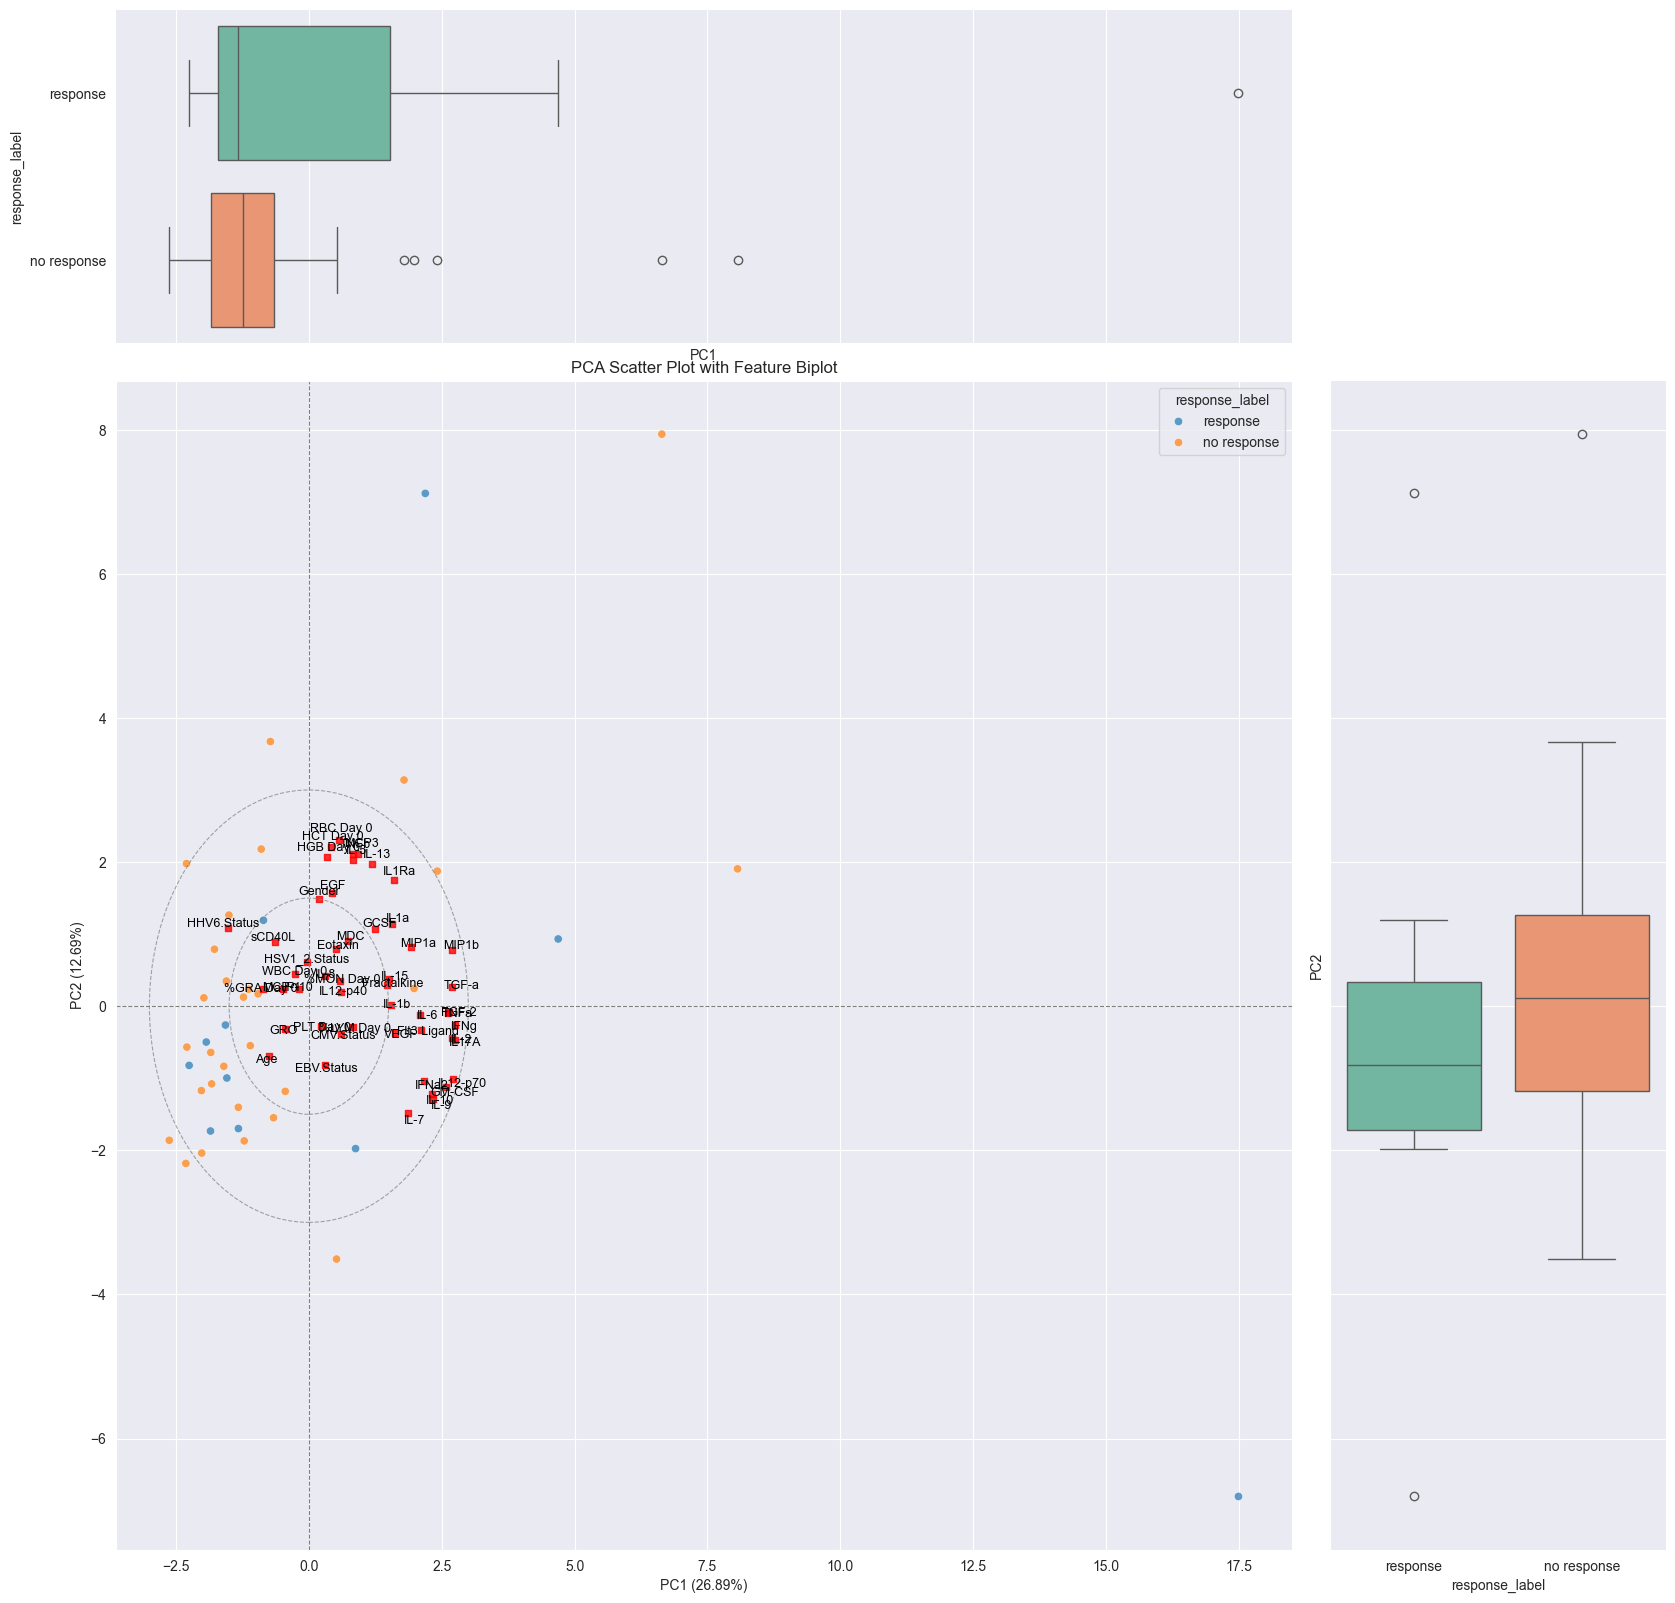

In [636]:
print(merged_data.columns)
plot_pca_with_response_marginals(
    data=merged_data.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    pc1_err_col=None,  # Provide error columns if available
    pc2_err_col=None
)

Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'FGF-2', 'Eotaxin', 'TGF-a',
       'Flt3 Ligand', 'IFNg', 'GRO', 'MDC', 'sCD40L', 'IL17A', 'IL1Ra', 'IL-8',
       'IP-10', 'MCP-1', 'MIP1a', 'MIP1b', 'TNFa', 'VEGF', 'WBC Day 0',
       'RBC Day 0', 'HGB Day 0', 'HCT Day 0', 'PLT Day 0', '%LYM Day 0',
       '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')


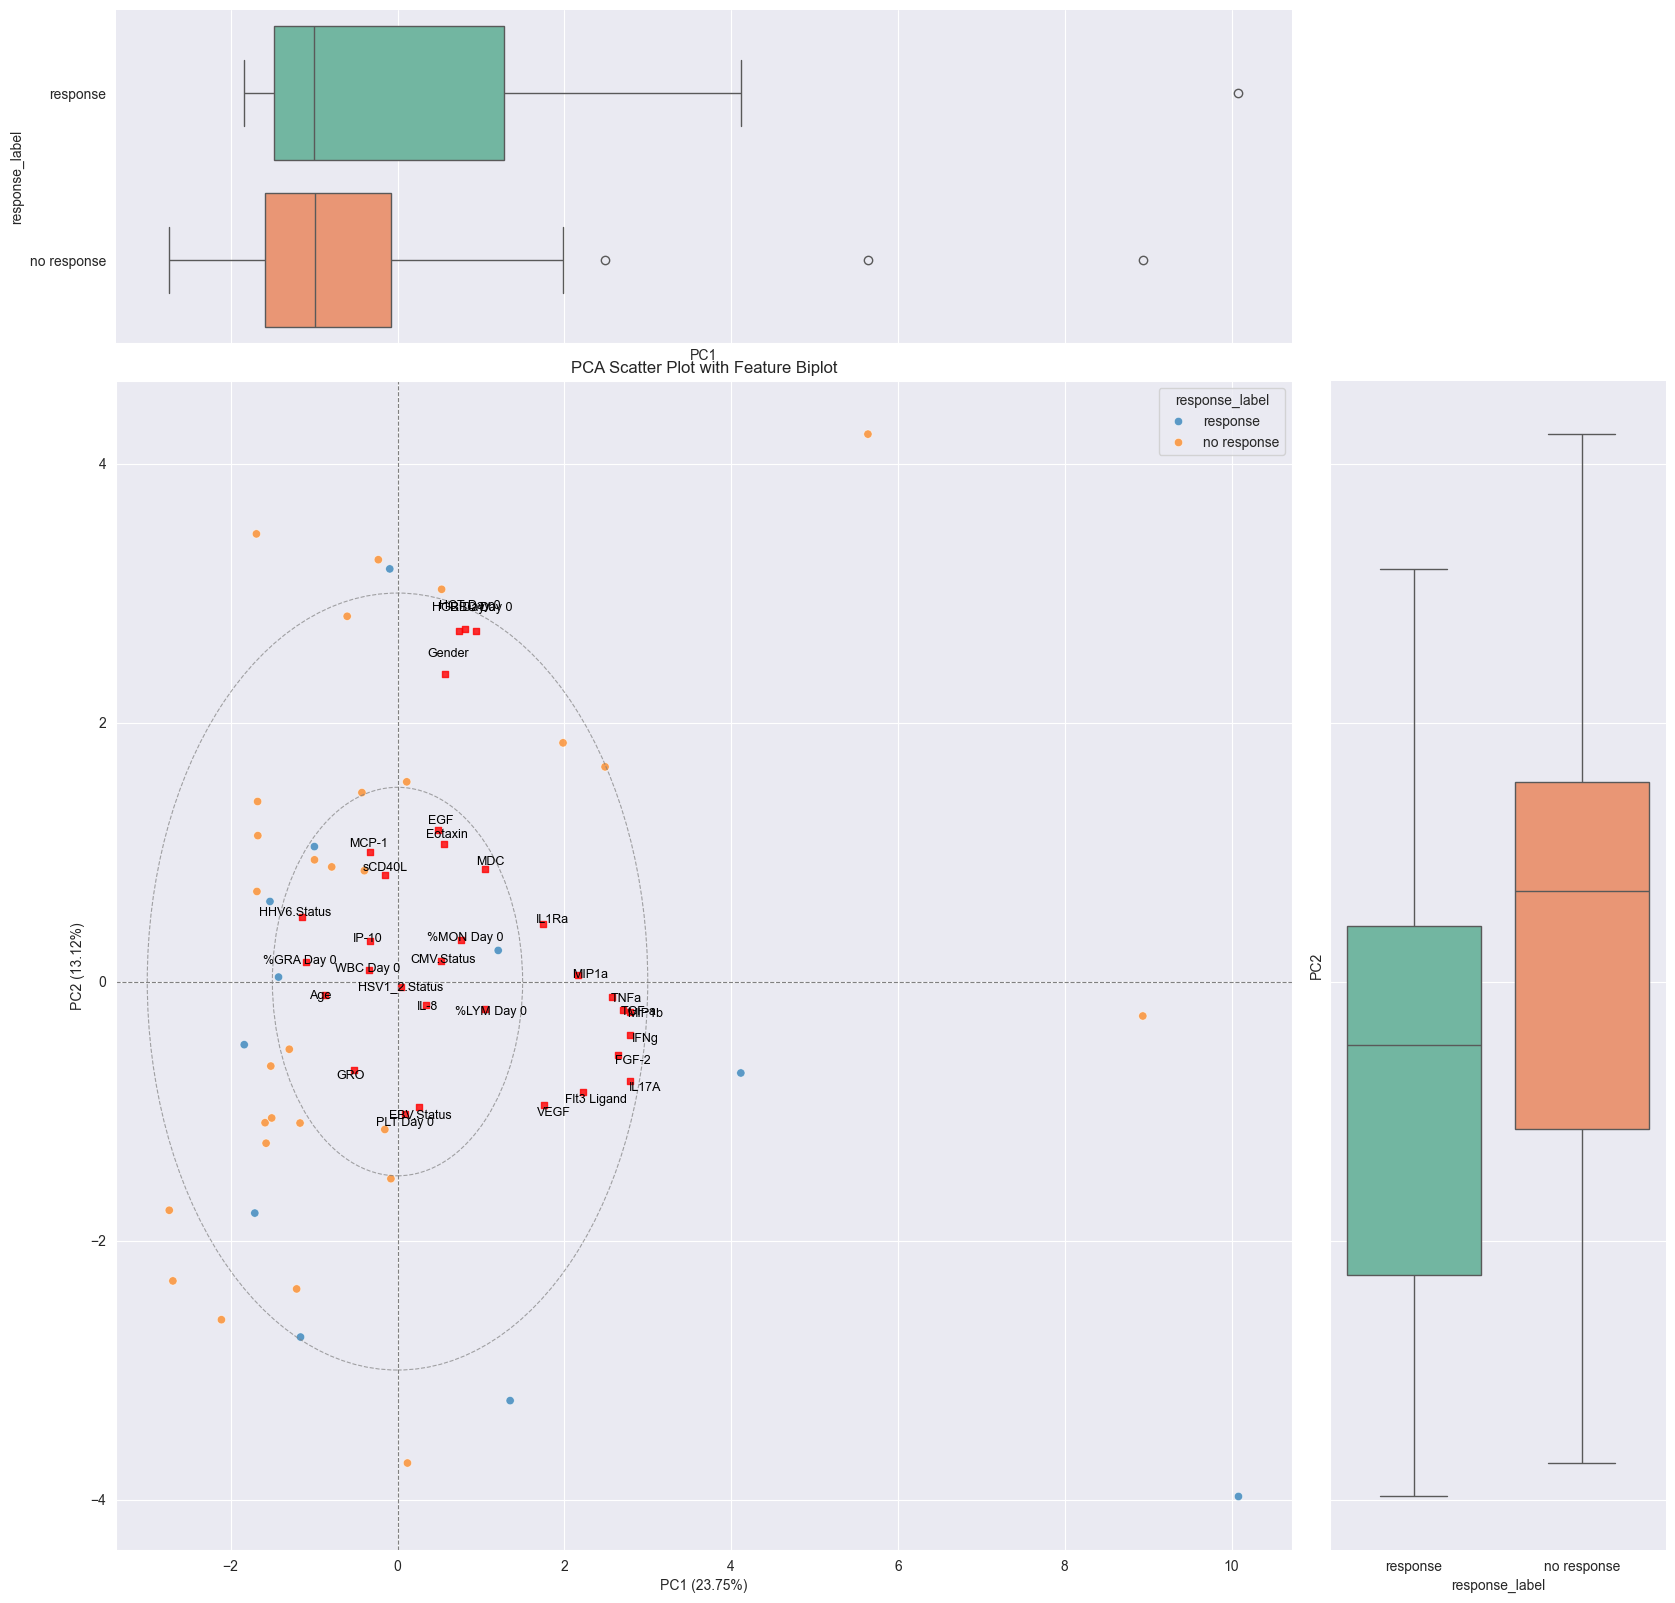

In [637]:
# Cytokines that don't deviate from the limit of detection
cytokines_to_remove = [
    "GCSF",
    "GM-CSF",
    "Fractalkine",
    "IFNa2",
    "IL-10",
    "MCP3",
    "IL12-p40",
    "IL12-p70",
    "IL-13",
    "IL-15",
    "IL1a",
    "IL-9",
    "IL-1b",
    "IL-2",
    # "IL-3", i don't have these
    # "IL-4", i don't have these
    "IL-5",
    "IL-6",
    "IL-7",
    "TNFb"
]


# Prepare your data
merged_data_less_cytokines = merged_data.drop(columns=cytokines_to_remove)

print(merged_data_less_cytokines.columns)
plot_pca_with_response_marginals(
    data=merged_data_less_cytokines.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    pc1_err_col=None,  # Provide error columns if available
    pc2_err_col=None
)

In [638]:
#looking at correlation_heatmap_merged_ward2.png
# if filter_out_cytokines_to_remove = True look at correlation_heatmap_merged_(removed_some_cytokines)_ward2.png
filter_out_cytokines_to_remove = False

# Define the groups of correlated features
if filter_out_cytokines_to_remove:
    groups = {
        "group_1": ['Gender', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0'],
        "group_2": ['IFNg', 'IL17A', 'TGF-a', 'TNFa', 'MIP1b', 'FGF-2', 'Flt3 Ligand', 'VEGF'],
    }
else:
    groups = {
        "group_1": ['IL1Ra', 'TNFb', 'MCP3', 'IL-13'],
        "group_2": ['IL-9', 'IL-10', 'GM-CSF', 'IL-2', 'IL-7', 'IFNa2'],
        "group_3": ['Gender', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0'],
        "group_4": ['IL12-p70', 'IFNg', 'IL17A', 'TGF-a', 'TNFa', 'MIP1b', 'FGF-2', 'Flt3 Ligand', 'VEGF', "IL-6"],
        "group_5": ['Fractalkine', 'IL-15', 'IL-1b']
    }

# Partial Least Squares Regression (PLS) would be the most appropriate method. PLS not only reduces dimensionality but also ensures that the new components are most predictive of your target variable.
def compress_features(data, features, target, new_feature_name, n_components=1):
    # Ensure the target is not among the features
    features = [feat for feat in features if feat != target]
    
    # Check if features exist in the data
    missing_features = [feat for feat in features if feat not in data.columns]
    if missing_features:
        raise ValueError(f"The following features are missing from the data: {missing_features}")
    
    # Prepare the feature matrix X and target vector y
    X = data[features]
    y = data[target]
    
    # Handle missing values
    if X.isnull().any().any() or y.isnull().any():
        raise ValueError("Missing values detected. Please handle them before proceeding.")
    
    # Encode target variable if it's categorical
    if y.dtype == 'object' or isinstance(y.dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        y = le.fit_transform(y)
        
    # Convert y to 2D array (required by scikit-learn)
    y = np.array(y).reshape(-1, 1)
    
    # Initialize and fit the PLS regression model
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, y)
    
    # Transform the features
    X_transformed = pls.transform(X)
    
    # Add the new compressed feature to the data
    data[new_feature_name] = X_transformed[:, 0]
    
    return data

# Ensure the `groups` dictionary is up-to-date and missing groups are handled
groups = {key: value for key, value in groups.items() if len(value) > 0}

# Compress the groups and create new features
merged_data_compressed_correlated = merged_data.copy()

for group_name, features in groups.items():
    compressed_feature_name = f"{group_name}_Compressed"
    merged_data_compressed_correlated = compress_features(
        merged_data_compressed_correlated, features, 'response_label', compressed_feature_name
    )

# Drop the original features that are now compressed
features_to_drop = [feature for group in groups.values() for feature in group]
merged_data_compressed_correlated.drop(columns=features_to_drop, inplace=True)
if filter_out_cytokines_to_remove:
    drop = [item for item in cytokines_to_remove if item not in features_to_drop]
    merged_data_compressed_correlated = merged_data_compressed_correlated.drop(columns=drop)

print("Features compressed and original features dropped.")

Features compressed and original features dropped.


Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'Eotaxin', 'GCSF', 'GRO',
       'IL12-p40', 'MDC', 'sCD40L', 'IL1a', 'IL-5', 'IL-8', 'IP-10', 'MCP-1',
       'MIP1a', 'WBC Day 0', 'PLT Day 0', '%LYM Day 0', '%MON Day 0',
       '%GRA Day 0', 'Age', 'group_1_Compressed', 'group_2_Compressed',
       'group_3_Compressed', 'group_4_Compressed', 'group_5_Compressed'],
      dtype='object')


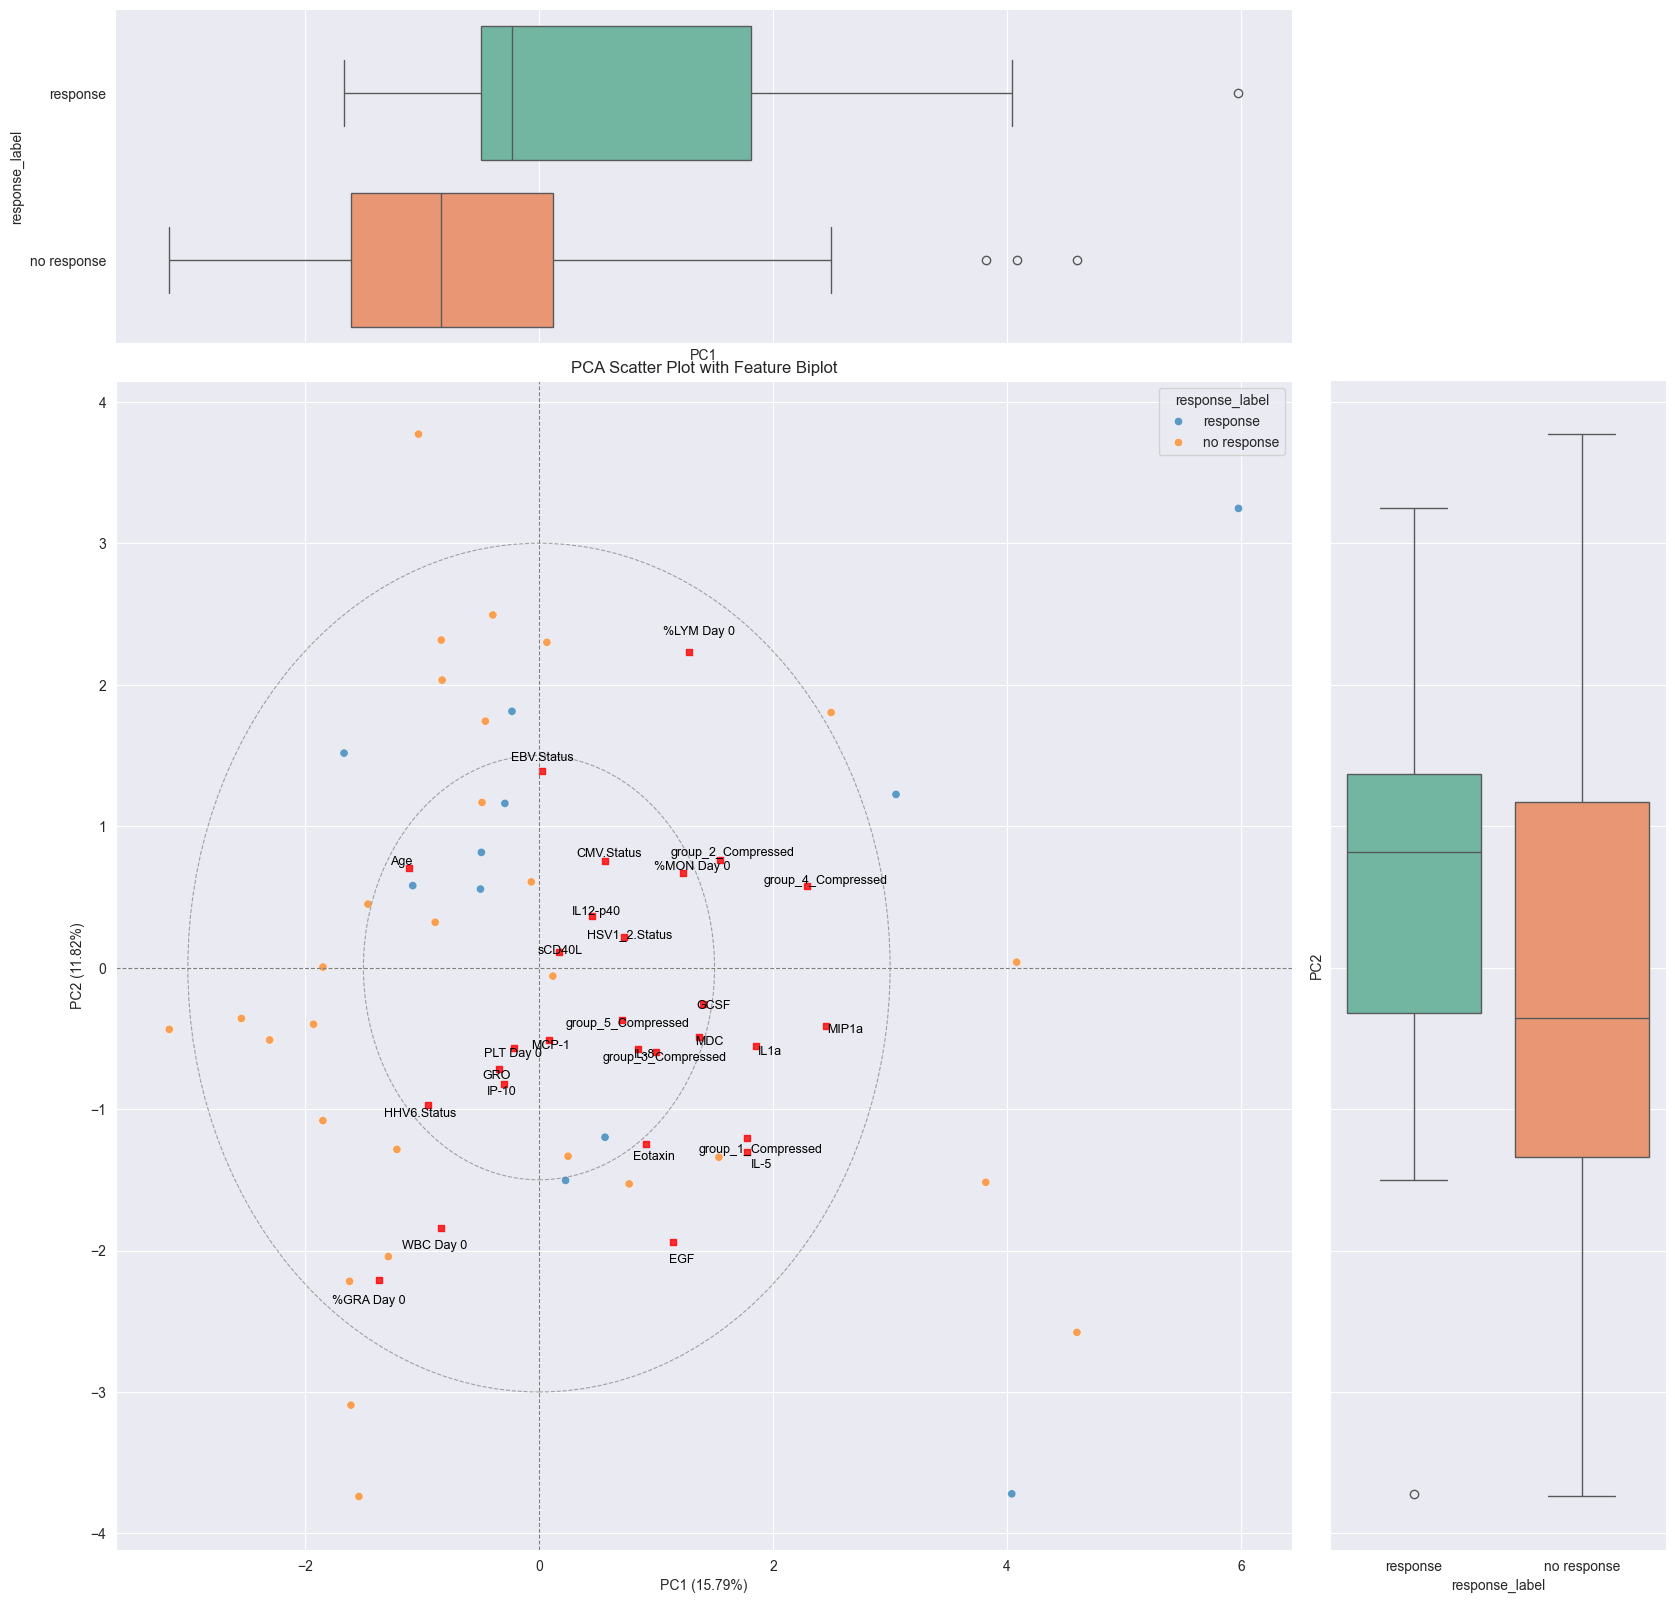

In [639]:
print(merged_data_compressed_correlated.columns)
plot_pca_with_response_marginals(
    data=merged_data_compressed_correlated.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    pc1_err_col=None,  # Provide error columns if available
    pc2_err_col=None
)

## Try different projection model

In [640]:
# https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2021.787574/full
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04054-2


def _add_reference_circles(ax, center, radii=[0.5, 1.0], color='gray', linestyle='--', linewidth=0.8, alpha=0.5):
    for radius in radii:
        circle = plt.Circle((center[0], center[1]), radius, color=color, fill=False, linestyle=linestyle, linewidth=linewidth, alpha=alpha)
        ax.add_artist(circle)

def plot_umap_with_response_marginals(
    data, 
    numeric_features=None, 
    response_label_col='response_label', 
    excluded_features=[], 
    n_neighbors=15, 
    min_dist=0.1, 
    n_components=2,
    verbose=False
):
    """
    Plots a UMAP scatter plot with marginal boxplots grouped by response and non-response labels,
    and includes reference circles for visualizing feature separation.

    Parameters:
    - data (pd.DataFrame): The input dataframe containing the data.
    - numeric_features (list, optional): List of numeric feature columns for UMAP if not already reduced.
    - response_label_col (str): Column indicating response labels (e.g., 'response' or 'no response').
    - excluded_features (list): Features to exclude from UMAP analysis.
    - n_neighbors (int): Number of neighbors for UMAP.
    - min_dist (float): Minimum distance between embedded points for UMAP.
    - n_components (int): Number of UMAP components to compute.
    - verbose (bool): Whether to print additional details.
    """
    # Select numeric features for UMAP
    if numeric_features is None:
        numeric_features = data.select_dtypes(include=[float, int]).columns.tolist()
        excluded_columns = [response_label_col, 'Vaccinee']
        excluded_columns.extend(excluded_features)
        numeric_features = [col for col in numeric_features if col not in excluded_columns]

    # Standardize the numeric features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[numeric_features])
    
    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    umap_embedding = reducer.fit_transform(X_scaled)
    
    # Add UMAP components to the data
    for i in range(n_components):
        data[f"UMAP{i+1}"] = umap_embedding[:, i]
        
    # Compute feature contributions: Correlation of each feature with UMAP components
    feature_contributions = {}
    for i in range(n_components):
        umap_col = f"UMAP{i+1}"
        feature_contributions[umap_col] = {}
        for feature in numeric_features:
            corr = np.corrcoef(data[feature], data[umap_col])[0, 1]
            feature_contributions[umap_col][feature] = corr

    if verbose:
        print("\nFeature Contributions to UMAP Components:")
        for umap_col, contributions in feature_contributions.items():
            print(f"{umap_col}:")
            sorted_features = sorted(contributions.items(), key=lambda x: abs(x[1]), reverse=True)
            for feature, value in sorted_features:
                print(f"  {feature}: {value:.4f}")
    
    # Create the plot
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(2, 2, width_ratios=(7, 2), height_ratios=(2, 7), wspace=0.05, hspace=0.05)
    ax_scatter = fig.add_subplot(gs[1, 0])
    ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
    ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

    # Scatter plot grouped by response labels
    scatter_kwargs = {'data': data, 'x': 'UMAP1', 'y': 'UMAP2', 'ax': ax_scatter, 'alpha': 0.7}
    scatter_kwargs['hue'] = response_label_col
    sns.scatterplot(**scatter_kwargs)
    
    
    # Calculate the centroid of the UMAP embedding
    umap1_center = (data['UMAP1'].max() + data['UMAP1'].min()) / 2
    umap2_center = (data['UMAP2'].max() + data['UMAP2'].min()) / 2
    
    visual_multiplier = 1  # Adjust as needed for scaling feature contributions
    
    # Plot feature contributions as squares around the new center
    for feature in numeric_features:
        umap1_corr = feature_contributions['UMAP1'][feature]
        umap2_corr = feature_contributions['UMAP2'][feature]
    
        # Adjust the plotting coordinates to be relative to the single center
        adjusted_umap1 = umap1_center + umap1_corr * visual_multiplier
        adjusted_umap2 = umap2_center + umap2_corr * visual_multiplier
    
        ax_scatter.scatter(
            adjusted_umap1, adjusted_umap2,
            color='red', alpha=0.8, marker='s', s=20, label=feature if verbose else None
        )
        ax_scatter.text(
            adjusted_umap1 * visual_multiplier, adjusted_umap2 * visual_multiplier,
            feature, color='black', fontsize=9, ha='center', va='center'
        )
    
    # Add reference circles centered around the single center
    _add_reference_circles(
        ax_scatter, 
        center=(umap1_center, umap2_center), 
        radii=[0.5 * visual_multiplier, 1.0 * visual_multiplier], 
        color='gray', linestyle='--', linewidth=0.8, alpha=0.7
    )
    ax_scatter.axhline(umap2_center, color='gray', linewidth=0.8, linestyle='--')
    ax_scatter.axvline(umap1_center, color='gray', linewidth=0.8, linestyle='--')

    # Marginal boxplots grouped by response labels
    sns.boxplot(
        data=data, 
        x='UMAP1', 
        y=response_label_col, 
        orient='h', 
        ax=ax_hist_x, 
        hue=response_label_col, 
        palette="Set2", 
        dodge=False
    )
    sns.boxplot(
        data=data, 
        x=response_label_col, 
        y='UMAP2', 
        orient='v', 
        ax=ax_hist_y, 
        hue=response_label_col, 
        palette="Set2", 
        dodge=False
    )

    # Hide labels on marginal plots for cleaner visualization
    ax_hist_x.tick_params(axis='x', labelbottom=False)
    ax_hist_y.tick_params(axis='y', labelleft=False)

    # Adjust subplot visibility
    ax_hist_x.spines['top'].set_visible(False)
    ax_hist_x.spines['right'].set_visible(False)
    ax_hist_x.spines['left'].set_visible(False)
    ax_hist_y.spines['top'].set_visible(False)
    ax_hist_y.spines['right'].set_visible(False)
    ax_hist_y.spines['bottom'].set_visible(False)

    # Axis labels and title
    ax_scatter.set_xlabel("UMAP1")
    ax_scatter.set_ylabel("UMAP2")
    ax_scatter.tick_params(axis='x', labelbottom=False)
    ax_scatter.tick_params(axis='y', labelleft=False)
    ax_scatter.set_title("UMAP Scatter Plot with Marginals")

    plt.show()



Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'FGF-2', 'Eotaxin', 'TGF-a',
       'GCSF', 'Flt3 Ligand', 'GM-CSF', 'Fractalkine', 'IFNa2', 'IFNg', 'GRO',
       'IL-10', 'MCP3', 'IL12-p40', 'MDC', 'IL12-p70', 'IL-13', 'IL-15',
       'sCD40L', 'IL17A', 'IL1Ra', 'IL1a', 'IL-9', 'IL-1b', 'IL-2', 'IL-5',
       'IL-6', 'IL-7', 'IL-8', 'IP-10', 'MCP-1', 'MIP1a', 'MIP1b', 'TNFa',
       'TNFb', 'VEGF', 'WBC Day 0', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0',
       'PLT Day 0', '%LYM Day 0', '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')


/Users/eliasdams/School/Master 2/Thesis/Thesis/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Feature Contributions to UMAP Components:
UMAP1:
  MIP1b: -0.6824
  FGF-2: -0.5992
  IL-5: -0.5455
  IL1a: -0.5448
  IL1Ra: -0.5334
  MIP1a: -0.5309
  IL17A: -0.5285
  IFNg: -0.5185
  IL-13: -0.5119
  IL-6: -0.5107
  Flt3 Ligand: -0.4723
  GRO: 0.4696
  TGF-a: -0.4651
  MCP3: -0.4551
  IL-2: -0.4431
  RBC Day 0: -0.4383
  TNFa: -0.4377
  %GRA Day 0: 0.4262
  %LYM Day 0: -0.4241
  TNFb: -0.4181
  Fractalkine: -0.4157
  IL12-p70: -0.4001
  HCT Day 0: -0.3759
  Gender: -0.3739
  IFNa2: -0.3732
  IL-1b: -0.3686
  GCSF: -0.3543
  HGB Day 0: -0.3498
  GM-CSF: -0.3325
  IL-15: -0.3255
  MDC: -0.2803
  VEGF: -0.2744
  IL-9: -0.2685
  CMV.Status: -0.2654
  IL-10: -0.2594
  Age: 0.2529
  Eotaxin: -0.2505
  HHV6.Status: 0.2271
  PLT Day 0: 0.2099
  EGF: -0.1798
  %MON Day 0: -0.1597
  WBC Day 0: 0.1270
  EBV.Status: -0.1213
  MCP-1: -0.1180
  IL12-p40: -0.0954
  IP-10: 0.0931
  IL-7: -0.0584
  IL-8: -0.0559
  sCD40L: 0.0232
  HSV1_2.Status: 0.0060
UMAP2:
  Gender: 0.8036
  HCT Day 0: 0.7800
  HG

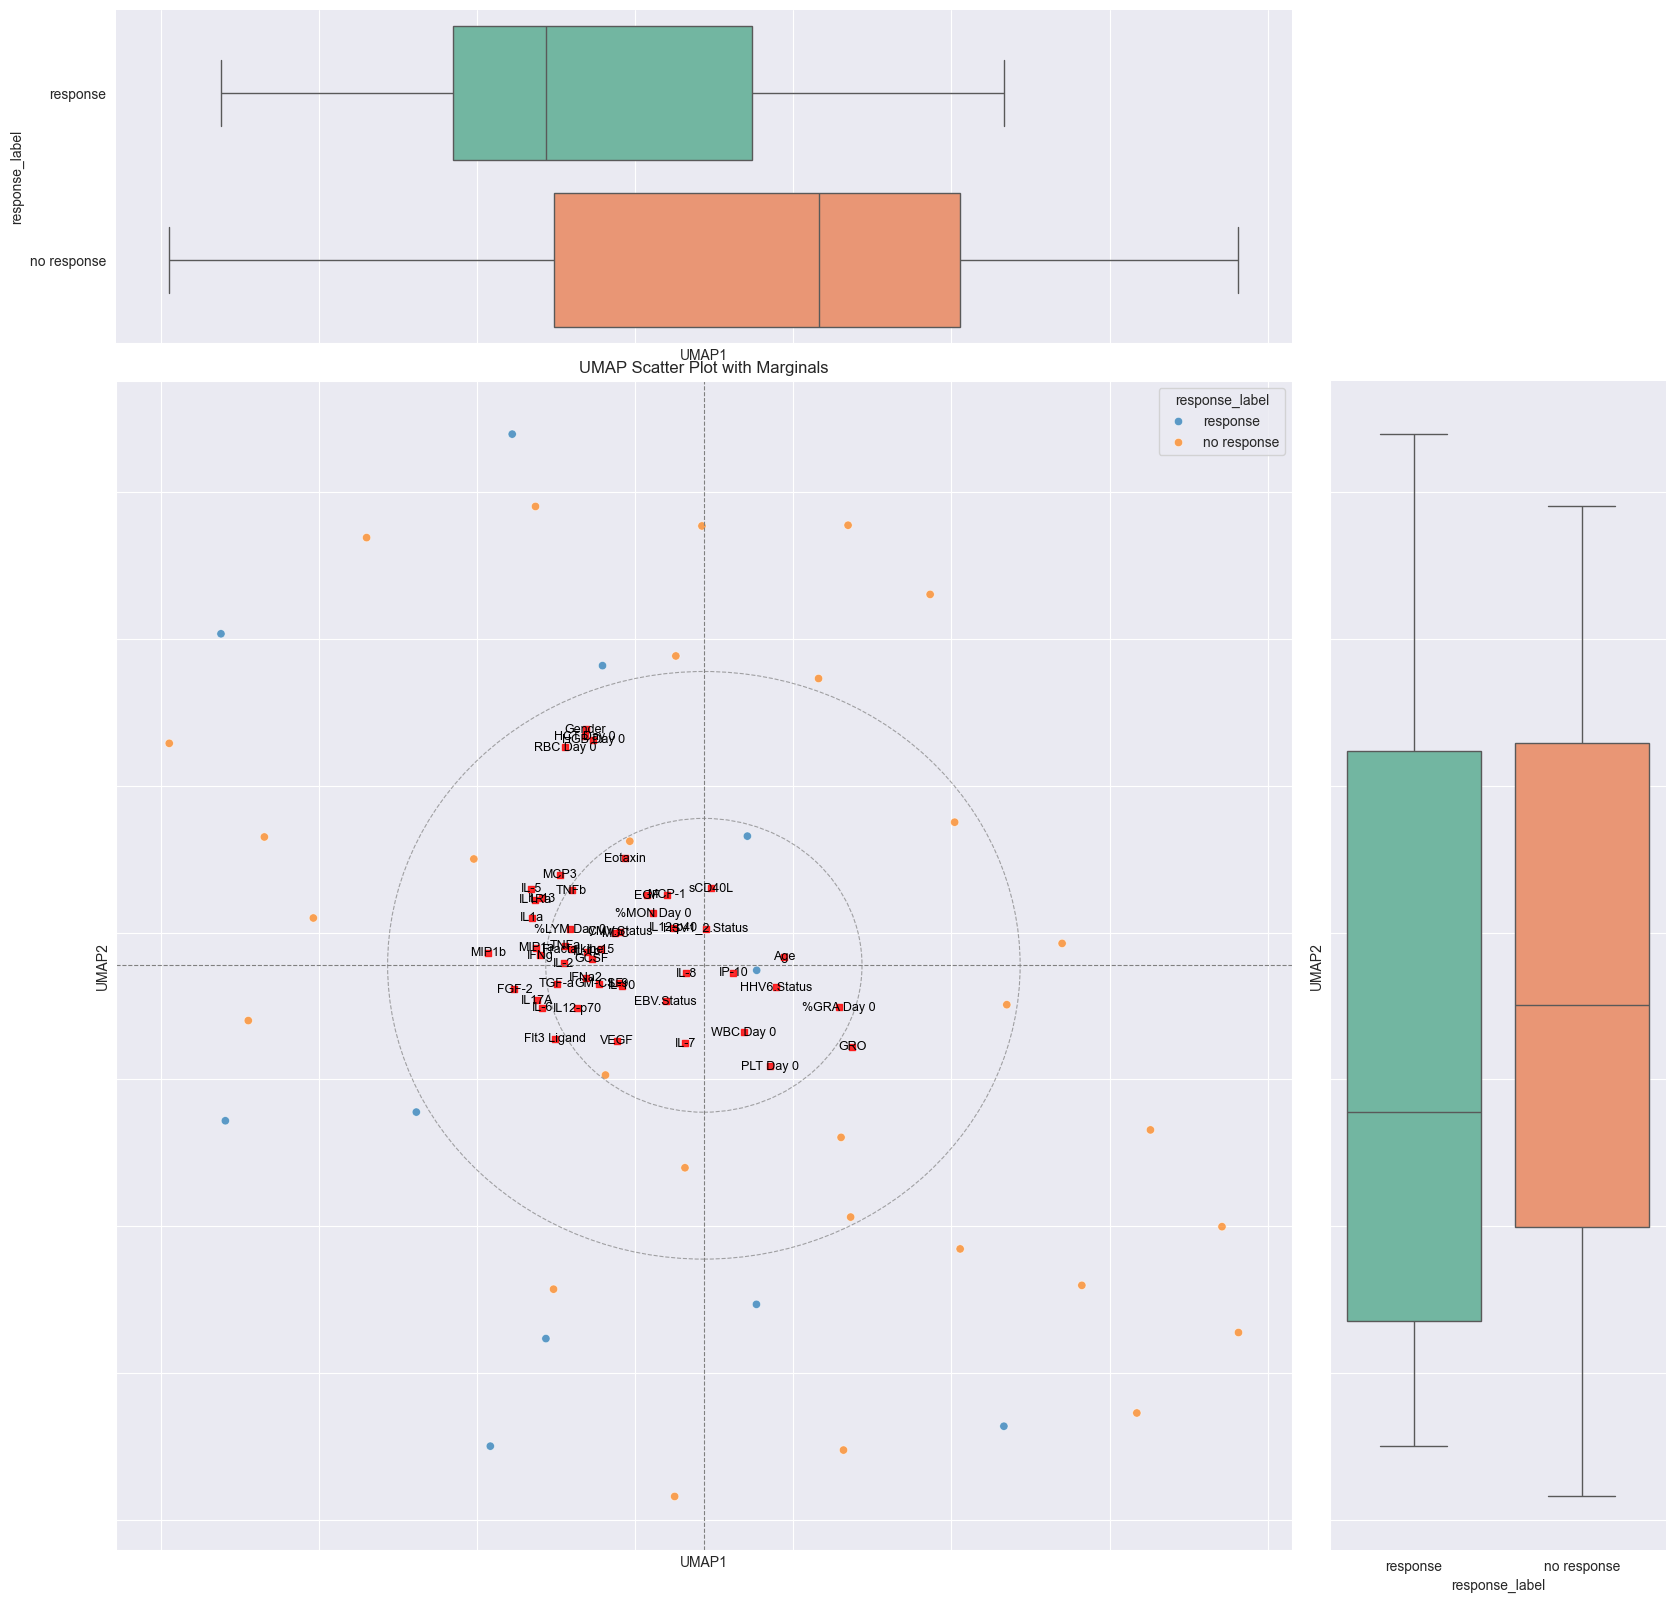

In [641]:
print(merged_data.columns)
plot_umap_with_response_marginals(
    data=merged_data.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    verbose=True,
)

Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'FGF-2', 'Eotaxin', 'TGF-a',
       'Flt3 Ligand', 'IFNg', 'GRO', 'MDC', 'sCD40L', 'IL17A', 'IL1Ra', 'IL-8',
       'IP-10', 'MCP-1', 'MIP1a', 'MIP1b', 'TNFa', 'VEGF', 'WBC Day 0',
       'RBC Day 0', 'HGB Day 0', 'HCT Day 0', 'PLT Day 0', '%LYM Day 0',
       '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')


/Users/eliasdams/School/Master 2/Thesis/Thesis/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Feature Contributions to UMAP Components:
UMAP1:
  FGF-2: -0.6103
  TGF-a: -0.6071
  IL17A: -0.5693
  VEGF: -0.5641
  IFNg: -0.5482
  MIP1b: -0.5251
  TNFa: -0.4646
  IP-10: 0.3948
  MCP-1: 0.3794
  EBV.Status: -0.3519
  MIP1a: -0.3476
  Flt3 Ligand: -0.3240
  sCD40L: 0.3101
  PLT Day 0: -0.2988
  EGF: 0.2849
  %MON Day 0: -0.2776
  Eotaxin: 0.2542
  CMV.Status: -0.2324
  IL1Ra: -0.1670
  HHV6.Status: 0.1632
  HSV1_2.Status: -0.1554
  %GRA Day 0: 0.1490
  GRO: 0.1309
  MDC: 0.1302
  %LYM Day 0: -0.1144
  Age: 0.0880
  IL-8: -0.0859
  HCT Day 0: -0.0673
  WBC Day 0: 0.0559
  RBC Day 0: -0.0399
  HGB Day 0: -0.0363
  Gender: -0.0251
UMAP2:
  HCT Day 0: -0.8245
  HGB Day 0: -0.8203
  Gender: -0.8064
  RBC Day 0: -0.8031
  GRO: 0.5319
  IFNg: -0.3912
  PLT Day 0: 0.3598
  MIP1b: -0.3259
  TNFa: -0.3200
  Eotaxin: -0.2952
  FGF-2: -0.2891
  CMV.Status: -0.2665
  MIP1a: -0.2663
  IL17A: -0.2611
  IL1Ra: -0.2556
  %GRA Day 0: 0.2536
  TGF-a: -0.2527
  %LYM Day 0: -0.2354
  MDC: -0.2045
  %MO

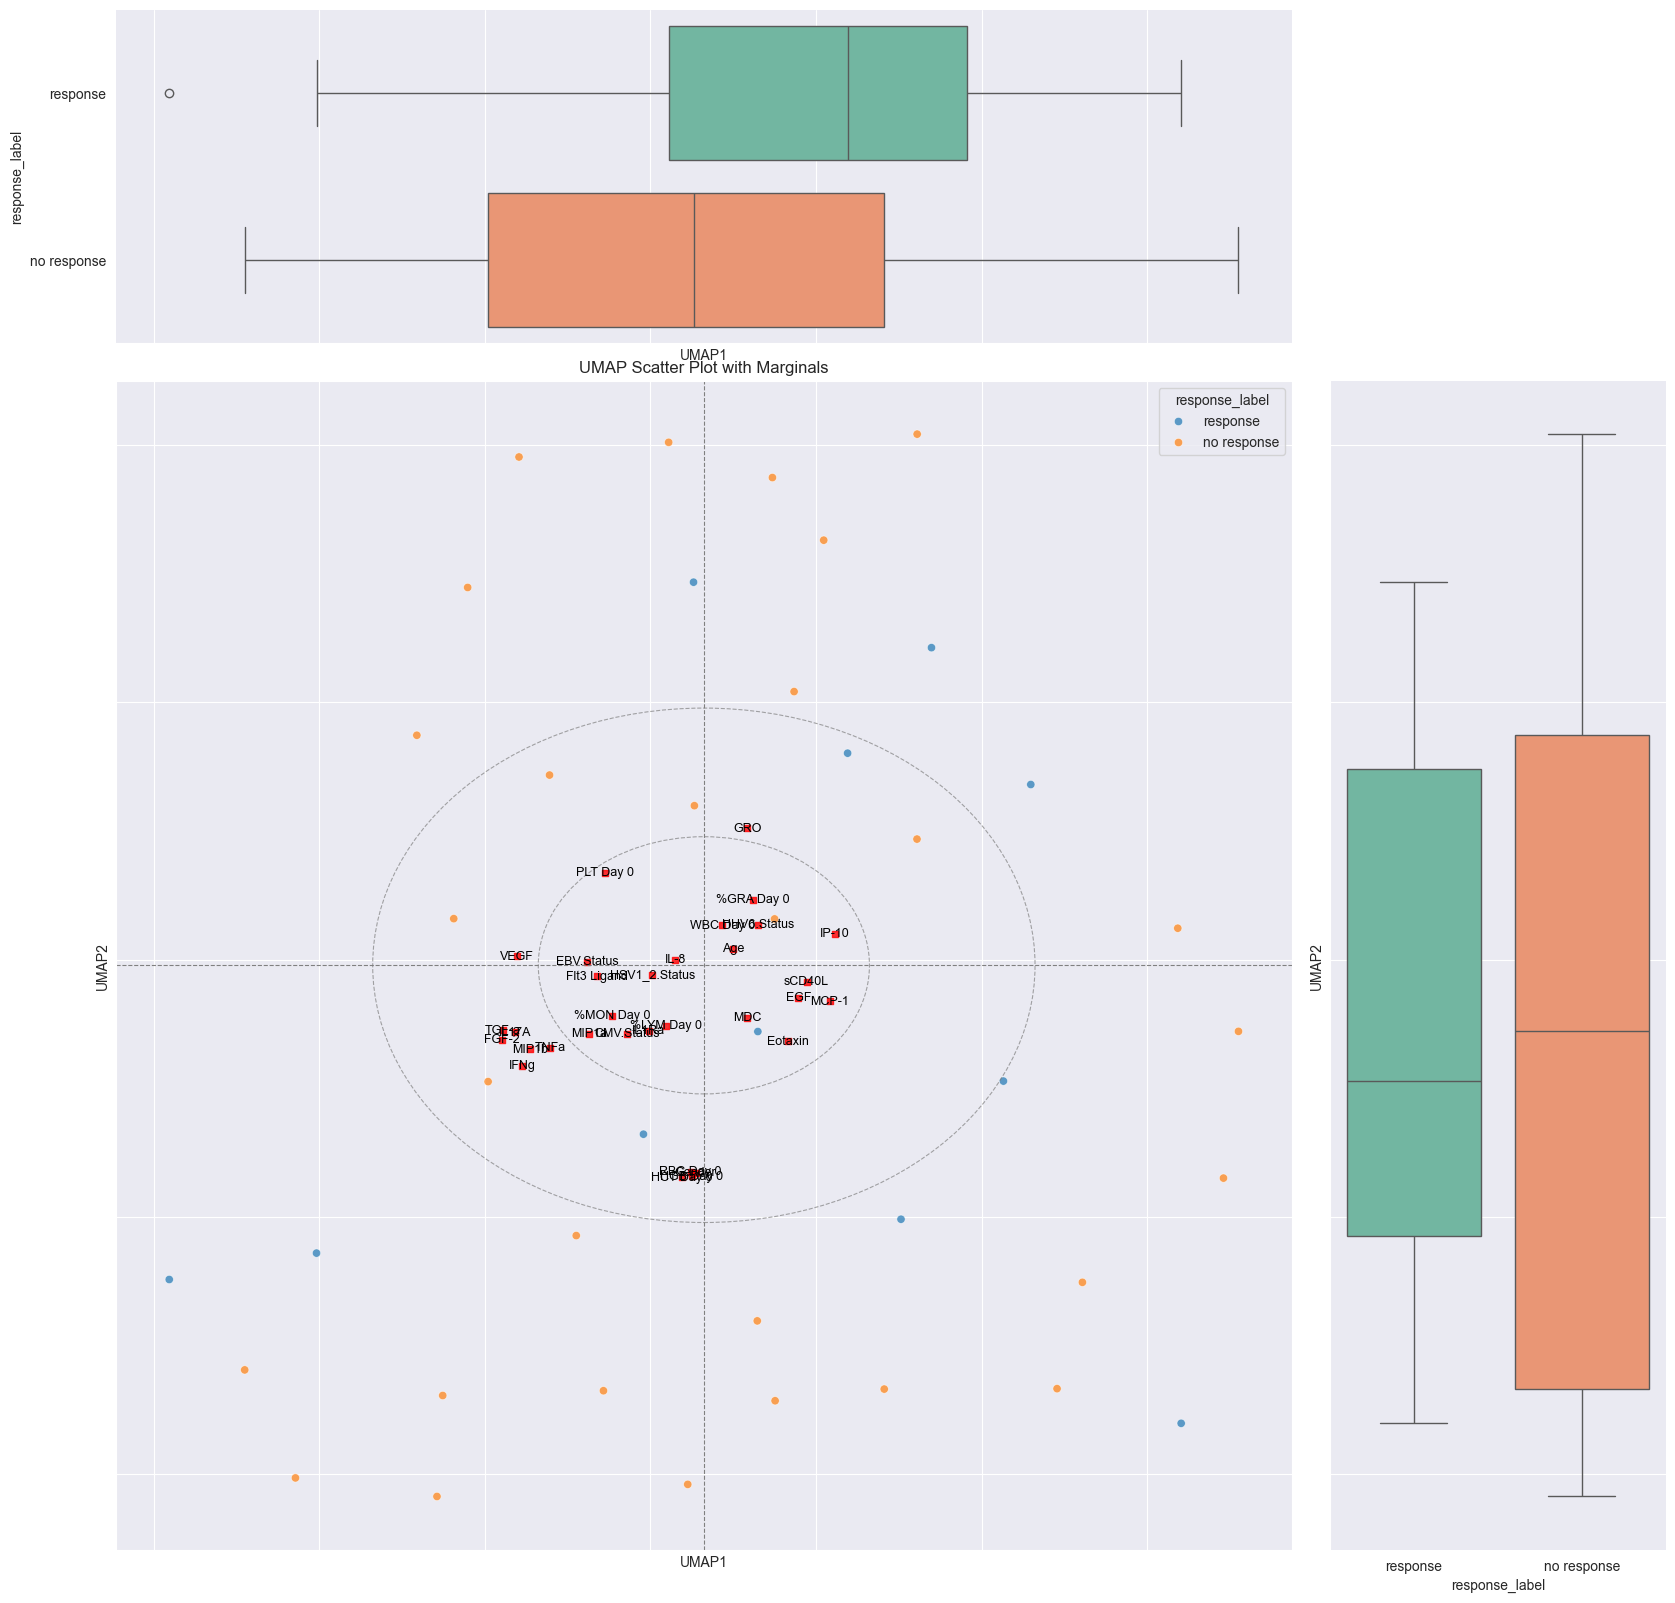

In [642]:
print(merged_data_less_cytokines.columns)
plot_umap_with_response_marginals(
    data=merged_data_less_cytokines.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    verbose=True,
)

Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'Eotaxin', 'GCSF', 'GRO',
       'IL12-p40', 'MDC', 'sCD40L', 'IL1a', 'IL-5', 'IL-8', 'IP-10', 'MCP-1',
       'MIP1a', 'WBC Day 0', 'PLT Day 0', '%LYM Day 0', '%MON Day 0',
       '%GRA Day 0', 'Age', 'group_1_Compressed', 'group_2_Compressed',
       'group_3_Compressed', 'group_4_Compressed', 'group_5_Compressed'],
      dtype='object')


/Users/eliasdams/School/Master 2/Thesis/Thesis/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Feature Contributions to UMAP Components:
UMAP1:
  %GRA Day 0: 0.6878
  %LYM Day 0: -0.6739
  CMV.Status: -0.5788
  group_4_Compressed: -0.4383
  GRO: 0.4285
  IL1a: -0.3946
  PLT Day 0: 0.3721
  HHV6.Status: 0.3714
  WBC Day 0: 0.3672
  MIP1a: -0.3261
  %MON Day 0: -0.3184
  EBV.Status: -0.2628
  group_2_Compressed: -0.2586
  IP-10: 0.2536
  GCSF: -0.2445
  group_3_Compressed: -0.2284
  IL-5: -0.2186
  MDC: -0.1951
  EGF: 0.1932
  sCD40L: -0.1884
  HSV1_2.Status: -0.1836
  group_1_Compressed: -0.1543
  IL-8: -0.1160
  group_5_Compressed: 0.0925
  Age: 0.0754
  Eotaxin: 0.0687
  IL12-p40: -0.0179
  MCP-1: 0.0032
UMAP2:
  EGF: 0.5829
  IL-5: 0.5800
  Eotaxin: 0.5624
  IL1a: 0.5147
  group_1_Compressed: 0.4588
  MDC: 0.4210
  WBC Day 0: 0.3821
  MCP-1: 0.3710
  IP-10: 0.3447
  %LYM Day 0: -0.3427
  group_3_Compressed: 0.3361
  EBV.Status: -0.3345
  %GRA Day 0: 0.3267
  MIP1a: 0.3193
  Age: -0.2946
  sCD40L: 0.1966
  group_5_Compressed: 0.1736
  HSV1_2.Status: -0.1693
  CMV.Status: 0.166

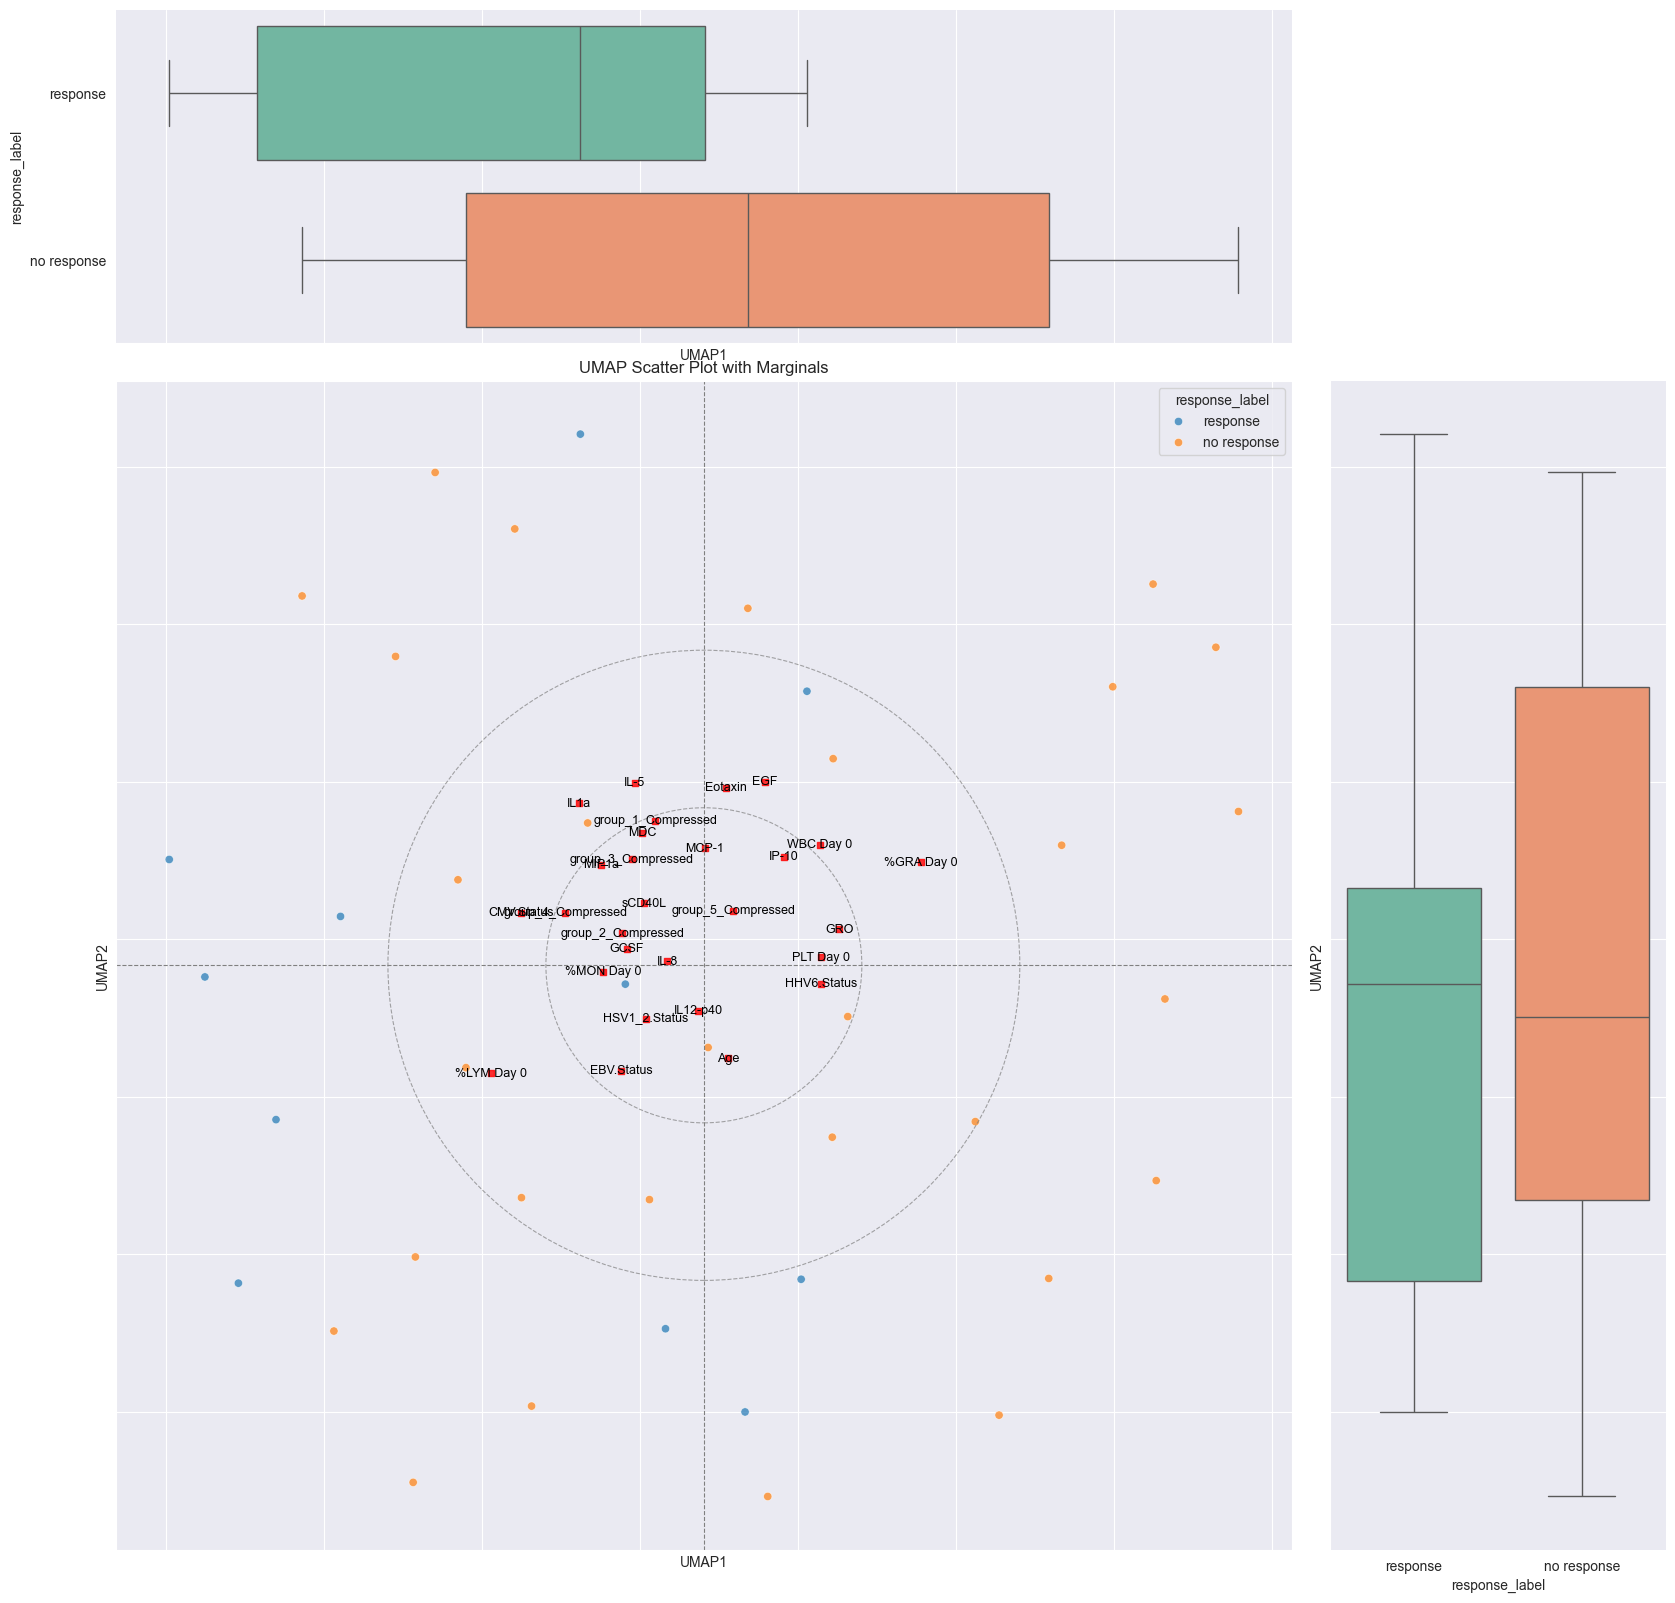

In [643]:
print(merged_data_compressed_correlated.columns)
plot_umap_with_response_marginals(
    data=merged_data_compressed_correlated.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    verbose=True,
)